In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
import random

In [19]:
file_1 = 'Small_Dataset_of_Good_APIs.csv'
production_data = pd.read_csv(file_1)

file_2 = 'DCA_All_Wells.csv'
parameters_data = pd.read_csv(file_2)

In [21]:
parameters_data.head()

,API_NUMBER,qi,di,b,sqrt_error,skipped_days,TimeStamp
0,5001097540000,53.91688,0.08649,1.84558,1.897326,0.0,2019/3/13 16:25:54
1,5001097600100,100.40589,0.01590,1.41683,1.728876,65.0,2019/3/13 16:26:3
2,5001098260000,374.54956,0.00766,0.78989,13.255572,29.0,2019/3/13 16:26:23
3,5001098470000,998.04971,0.01695,1.27165,63.488426,0.0,2019/3/13 16:27:11
4,5005071650100,225.97289,0.00367,0.55025,17.878265,0.0,2019/3/13 16:27:37


In [22]:
min_qi = parameters_data['qi'].quantile(0.05)
max_qi = parameters_data['qi'].quantile(0.95)

min_di = parameters_data['di'].quantile(0.05)
max_di = parameters_data['di'].quantile(0.95)

min_b = parameters_data['b'].quantile(0.05)
max_b = parameters_data['b'].quantile(0.95)

parameters_data['qi_norm'] = (parameters_data['qi']-min_qi)/(max_qi-min_qi)
parameters_data['di_norm'] = (parameters_data['di']-min_di)/(max_di-min_di)
parameters_data['b_norm'] = (parameters_data['b']-min_b)/(max_b-min_b)

In [23]:
ydata = parameters_data[['qi_norm', 'di_norm', 'b_norm']].as_matrix()
ydata.shape

(3540, 3)

In [42]:
t_length = 200
Xdata = np.zeros(shape=(parameters_data.shape[0], t_length, 2))-1
Xdata.shape

(3540, 200, 2)

In [43]:
sample = 0

max_cum_days = 0

for API_NUMBER in parameters_data['API_NUMBER']:
    #print(API_NUMBER, sample)
    selected_production_data = pd.DataFrame()
    selected_production_data = production_data.loc[production_data['API_NUMBER']==API_NUMBER, ['OIL_PROD_DAYS', 'OIL_PRODUCTION_BBL']]
    selected_production_data = selected_production_data.dropna()
    selected_production_data = selected_production_data.loc[selected_production_data['OIL_PRODUCTION_BBL']>0]
    selected_production_data['RATE_PROD'] = selected_production_data['OIL_PRODUCTION_BBL']/selected_production_data['OIL_PROD_DAYS']
    selected_production_data['CUM_DAYS'] = selected_production_data['OIL_PROD_DAYS'].cumsum()
    t = selected_production_data['CUM_DAYS']
    q = selected_production_data['RATE_PROD']
    if (max_cum_days < selected_production_data['CUM_DAYS'].max()):
        max_cum_days = selected_production_data['CUM_DAYS'].max()
    Xdata[sample, 0:t.shape[0], 0] = t
    Xdata[sample, 0:t.shape[0], 1] = q
    sample += 1

In [44]:
max_month = round(max_cum_days/30)
max_month

123.0

In [45]:
def func_hyp(t, qi, di, b):
    return qi/((1+di*b*t)**(1/b))

In [46]:
number_of_synth_examples = 20000

Xdata_synth = np.zeros(shape=(number_of_synth_examples, t_length, 2))-1
ydata_synth = np.zeros(shape=(number_of_synth_examples, 3))

for i in range(number_of_synth_examples):
    #print(i)
    qi_synth = random.uniform(min_qi, max_qi)
    di_synth = random.uniform(min_di, max_di)
    b_synth = random.uniform(min_b, max_b)
    
    qi_synth_norm = (qi_synth-min_qi)/(max_qi-min_qi)
    di_synth_norm = (di_synth-min_di)/(max_di-min_di)
    b_synth_norm = (b_synth-min_b)/(max_b-min_b)
    
    
    ydata_synth[i, :] = [qi_synth_norm, di_synth_norm, b_synth_norm]
    
    cum_months_synth = random.randint(12, max_month)
    start_day_synth = random.randint(5,30)
    
    j=0
    for cum_days_synth in range(start_day_synth, cum_months_synth*30, 30):
        production_noise = random.random()
        production_synth = func_hyp(cum_days_synth, qi_synth, di_synth, b_synth)*(1+production_noise)
        Xdata_synth[i, j, :] = [cum_days_synth, production_synth]
        j += 1

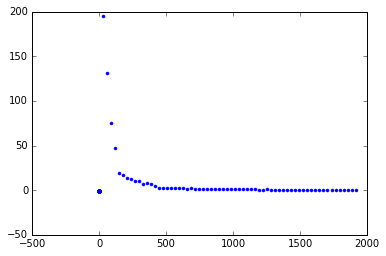

In [47]:
sample_for_plot = 670

plt.plot(Xdata_synth[sample_for_plot,:,0], Xdata_synth[sample_for_plot,:,1], 'b.')
plt.show()

In [48]:
import keras
from keras.models import Sequential  
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import InputLayer
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [49]:
input_shape = (None, t_length, 2)

In [50]:
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split( Xdata_synth, ydata_synth, test_size=0.20, random_state=7)

In [51]:
def run_model(LSTM_1, LSTM_2, DENSE_1, X_train_synth, y_train_synth, X_test_synth, y_test_synth):

    model = Sequential([
        InputLayer(batch_input_shape=input_shape),
        LSTM(LSTM_1, return_sequences=True),# dropout=0.2), #recurrent_dropout=0.2),
        LSTM(LSTM_2, return_sequences=False),
        Dense(DENSE_1, activation='relu'),
        Dense(3, activation='relu')])

    print(model.summary())

    opt = optimizers.Adam(lr=0.001)

    model.compile(loss='mae', optimizer=opt, metrics=['mae'])
    
    early_stopping = EarlyStopping(patience=5, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
    model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
    #tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

    history_synth = model.fit(X_train_synth, y_train_synth, batch_size=64, epochs=20, 
                          validation_data=(X_test_synth, y_test_synth), 
                          callbacks=[early_stopping, model_checkpoint, reduce_lr], verbose=0)
    
    val = history_synth.history['val_loss']
    print(val)
    
    epoch = history_synth.epoch
    loss = history_synth.history['loss']
    val = history_synth.history['val_loss']

    plt.plot(epoch, loss, 'b-')
    plt.plot(epoch, val, 'r.-')
    plt.show()
    
    return val

# in a terminal run:
# tensorboard --logdir ./Graph 
# it gives you access to TensorBoard and how your network is getting trained.

0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200, 50)           10600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 18        
Total params: 31,073
Trainable params: 31,073
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.24989, saving model to ./keras.model

Epoch 00002: val_loss did not improve from 0.24989

Epoch 00003: val_loss did not improve from 0.24989

Epoch 00004: val_loss did not improve from 0.24989

Epoch 00004: ReduceLROn

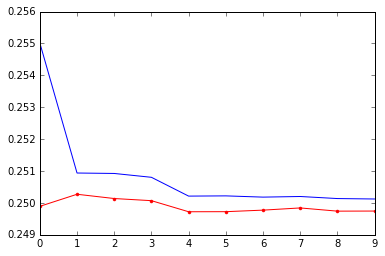

1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 200, 50)           10600     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 31,343
Trainable params: 31,343
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.24991, saving model to ./keras.model

Epoch 00002: val_loss improved from 0.24991 to 0.24979, saving model to ./keras.model

Epoch 00003: val_loss did not improve from 0.24979

Epoch 00004: val_loss did not improve fr

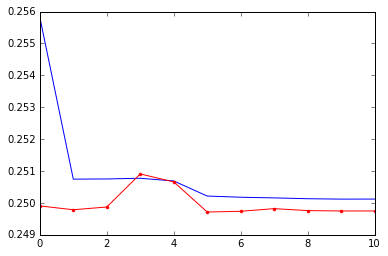

2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 200, 50)           10600     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 63        
Total params: 31,883
Trainable params: 31,883
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.33656, saving model to ./keras.model

Epoch 00002: val_loss did not improve from 0.33656

Epoch 00003: val_loss improved from 0.33656 to 0.33471, saving model to ./keras.model

Epoch 00004: val_loss did not improve fr

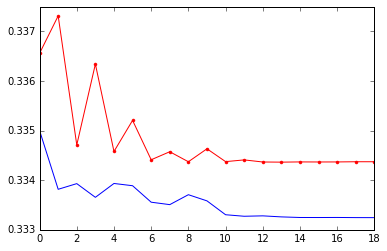

3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 200, 50)           10600     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 505       
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 18        
Total params: 71,523
Trainable params: 71,523
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.33217, saving model to ./keras.model

Epoch 00002: val_loss improved from 0.33217 to 0.33209, saving model to ./keras.model

Epoch 00003: val_loss did not improve from 0.33209

Epoch 00004: val_loss did not improve fr

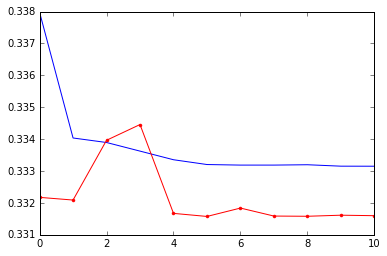

4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 200, 50)           10600     
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 33        
Total params: 72,043
Trainable params: 72,043
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.25120, saving model to ./keras.model

Epoch 00002: val_loss improved from 0.25120 to 0.25073, saving model to ./keras.model

Epoch 00003: val_loss improved from 0.25073 to 0.25064, saving model to ./keras.model

Epoch

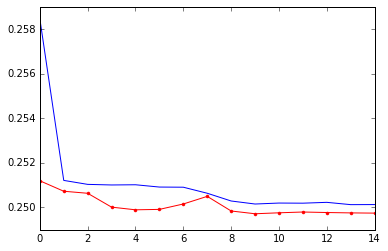

5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 200, 50)           10600     
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_13 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 63        
Total params: 73,083
Trainable params: 73,083
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.24996, saving model to ./keras.model

Epoch 00002: val_loss did not improve from 0.24996

Epoch 00003: val_loss improved from 0.24996 to 0.24971, saving model to ./keras.model

Epoch 00004: val_loss did not improve fr

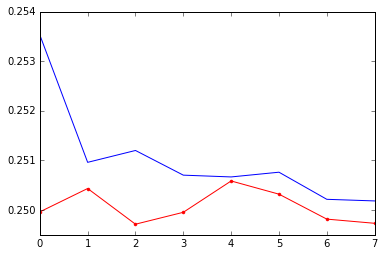

6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 200, 100)          41200     
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 255       
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 18        
Total params: 71,673
Trainable params: 71,673
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.41880, saving model to ./keras.model

Epoch 00002: val_loss improved from 0.41880 to 0.41736, saving model to ./keras.model

Epoch 00003: val_loss improved from 0.41736 to 0.41735, saving model to ./keras.model

Epoch

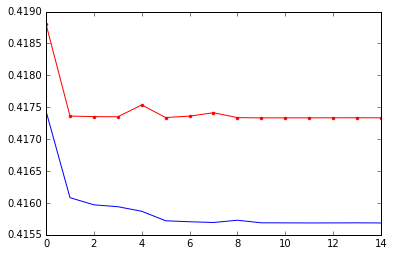

7
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 200, 100)          41200     
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 33        
Total params: 71,943
Trainable params: 71,943
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.33436, saving model to ./keras.model

Epoch 00002: val_loss did not improve from 0.33436

Epoch 00003: val_loss did not improve from 0.33436

Epoch 00004: val_loss did not improve from 0.33436

Epoch 00004: ReduceLROn

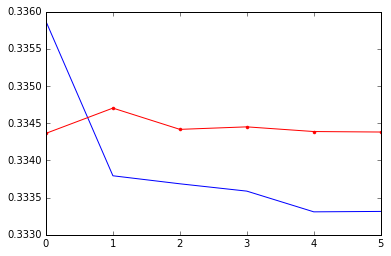

8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 200, 100)          41200     
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_19 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 63        
Total params: 72,483
Trainable params: 72,483
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.33481, saving model to ./keras.model

Epoch 00002: val_loss improved from 0.33481 to 0.33481, saving model to ./keras.model

Epoch 00003: val_loss improved from 0.33481 to 0.33440, saving model to ./keras.model

Epoch

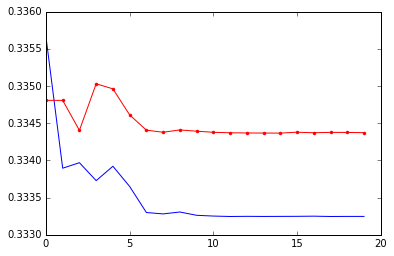

9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 200, 100)          41200     
_________________________________________________________________
lstm_22 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 505       
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 18        
Total params: 122,123
Trainable params: 122,123
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.25283, saving model to ./keras.model

Epoch 00002: val_loss improved from 0.25283 to 0.24992, saving model to ./keras.model

Epoch 00003: val_loss did not improve from 0.24992

Epoch 00004: val_loss did not improve 

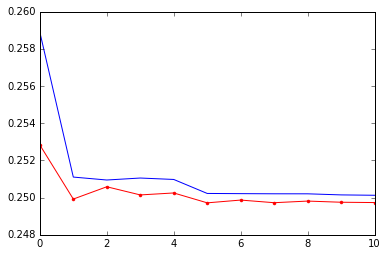

10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 200, 100)          41200     
_________________________________________________________________
lstm_24 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 33        
Total params: 122,643
Trainable params: 122,643
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.25038, saving model to ./keras.model

Epoch 00002: val_loss improved from 0.25038 to 0.24977, saving model to ./keras.model

Epoch 00003: val_loss did not improve from 0.24977

Epoch 00004: val_loss did not improve

KeyboardInterrupt: 

In [52]:
LSTM_1_space = [50, 100]
LSTM_2_space = [50, 100]
DENSE_1_space = [5, 10, 20]

val_history = np.zeros((3*3*3, 4))

i = 0
for LSTM_1 in LSTM_1_space:
    for LSTM_2 in LSTM_2_space:
        for DENSE_1 in DENSE_1_space:
            print(i)
            val_history[i, :] = [LSTM_1, LSTM_2, DENSE_1, min(run_model(LSTM_1, LSTM_2, DENSE_1, 
                                                                        X_train_synth, y_train_synth, 
                                                                        X_test_synth, y_test_synth))]
            i += 1

In [ ]:
LSTM_1 = 50
LSTM_2 = 50
DENSE_1 = 10

model = Sequential([InputLayer(batch_input_shape=input_shape),
                    LSTM(LSTM_1, return_sequences=True),# dropout=0.2), #recurrent_dropout=0.2),
                    LSTM(LSTM_2, return_sequences=False),
                    Dense(DENSE_1, activation='relu'),
                    Dense(3, activation='relu')])

print(model.summary())

opt = optimizers.Adam(lr=0.001)

model.compile(loss='mae', optimizer=opt, metrics=['mae'])
    
early_stopping = EarlyStopping(patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
#tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

history_synth = model.fit(X_train_synth, y_train_synth, batch_size=64, epochs=40, 
                          validation_data=(X_test_synth, y_test_synth), 
                          callbacks=[early_stopping, model_checkpoint, reduce_lr], verbose=2)

    
epoch = history_synth.epoch
loss = history_synth.history['loss']
val = history_synth.history['val_loss']

plt.plot(epoch, loss, 'b-')
plt.plot(epoch, val, 'r.-')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( Xdata, ydata, test_size=0.20, random_state=7)
X_train.shape

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, batch_size=16, epochs=100, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], verbose=2)

In [ ]:
epoch = history.epoch
loss = history.history['loss']
val = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.plot(epoch, loss, 'bx-', label='Training')
plt.plot(epoch, val, 'r.-', label='Validation')
plt.ylim(0.1, 0.4)
plt.xlim(0, 21)
plt.xticks(np.arange(0,21, 2))
plt.title('RNN Model Pre-Trained with Synthetic Data', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.legend()
plt.show()

In [32]:
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)

history2 = model.fit(X_train, y_train, batch_size=16, epochs=20, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], verbose=2)

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [29]:
epoch = history2.epoch
loss = history2.history['loss']
val = history2.history['val_loss']

plt.figure(figsize=(8,6))
plt.plot(epoch, loss, 'bx-', label='Training')
plt.plot(epoch, val, 'r.-', label='Validation')
plt.ylim(0.1, 0.4)
plt.xlim(0, 21)
plt.xticks(np.arange(0,21, 2))
plt.title('RNN Model Trained with Real Data only', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.legend()
plt.show()

NameError: name 'history2' is not defined

In [31]:
q_s_a_init()

array([[1.01002000e+05, 1.00000000e+00, 9.90947311e-01],
       [1.01002000e+05, 2.00000000e+00, 7.91652282e-01],
       [1.01002000e+05, 3.00000000e+00, 6.08223947e-01],
       [1.01002000e+05, 4.00000000e+00, 7.24252207e-02],
       [1.01002000e+05, 5.00000000e+00, 3.43089178e-01],
       [1.01002000e+05, 6.00000000e+00, 7.38894636e-01],
       [1.01004000e+05, 1.00000000e+00, 3.72378961e-01],
       [1.01004000e+05, 2.00000000e+00, 7.32016551e-01],
       [1.01004000e+05, 3.00000000e+00, 8.59374253e-01],
       [1.01004000e+05, 4.00000000e+00, 7.66575025e-01],
       [1.01004000e+05, 5.00000000e+00, 3.46708058e-03],
       [1.01004000e+05, 6.00000000e+00, 9.04903006e-01],
       [1.01006000e+05, 1.00000000e+00, 3.97040167e-01],
       [1.01006000e+05, 2.00000000e+00, 9.35289309e-01],
       [1.01006000e+05, 3.00000000e+00, 5.17480205e-01],
       [1.01006000e+05, 4.00000000e+00, 5.66321720e-01],
       [1.01006000e+05, 5.00000000e+00, 2.37791498e-01],
       [1.01006000e+05, 6.00000